In [5]:
# Generative A.I course by Javier Ideami
# Basic GAN Notebook

# Read a fun article about GANS that I wrote in medium:
# https://towardsdatascience.com/leonardo-and-the-gan-dream-f69e8553e0af?sk=c1fdf85e94c48acd61df451babc41dfe

# import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [6]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 x 784
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 1 x 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)   # 1 x 28 x 28  = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()


In [7]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs)

# number of steps = 60000 / 128 = 468.75

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.77MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
# declare our models

# Generator
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256 x 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
       return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

## Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)

In [9]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [10]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [11]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [12]:
x,y=next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([9, 2, 2, 3, 2, 5, 0, 4, 4, 2])


In [13]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred)
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach())
   disc_fake_targets=torch.zeros_like(disc_fake)
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss




  0%|          | 0/469 [00:00<?, ?it/s]

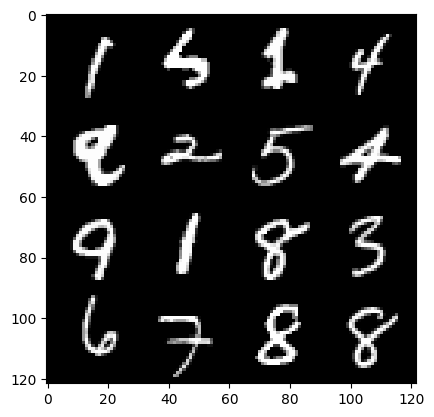

0: step 300 / Gen loss: 1.9617957673470179 / disc_loss: 0.3368745538095632


  0%|          | 0/469 [00:00<?, ?it/s]

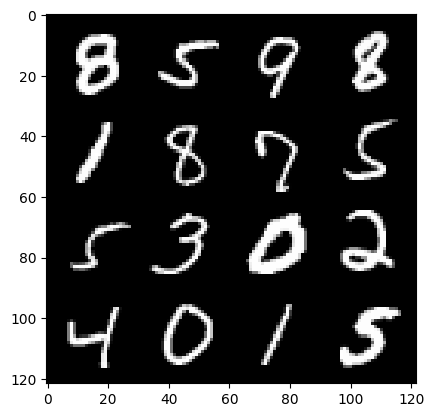

1: step 600 / Gen loss: 3.517496715386707 / disc_loss: 0.11478398347894339


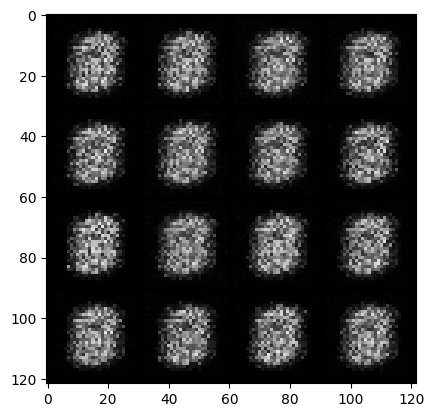

1: step 900 / Gen loss: 3.586892955303196 / disc_loss: 0.05118500337004664


  0%|          | 0/469 [00:00<?, ?it/s]

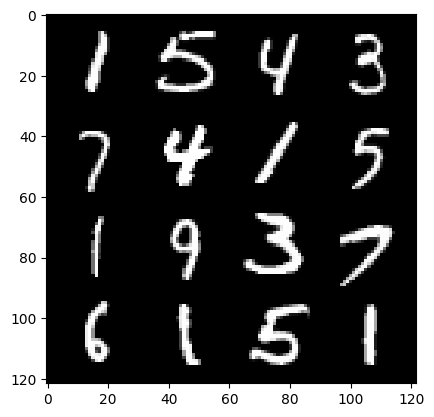

2: step 1200 / Gen loss: 3.6169813783963516 / disc_loss: 0.03425797048956157


  0%|          | 0/469 [00:00<?, ?it/s]

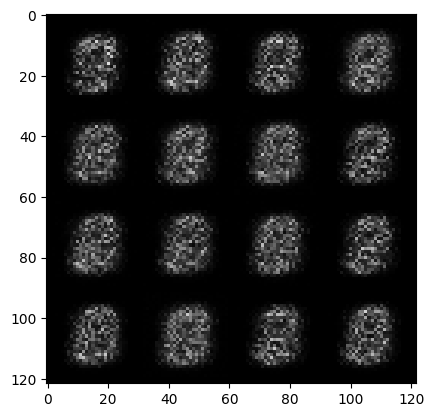

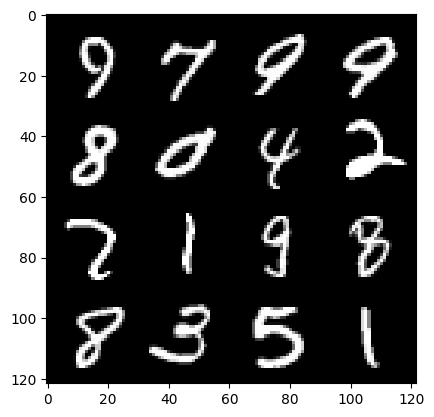

3: step 1500 / Gen loss: 3.386648637453714 / disc_loss: 0.045228164947281296


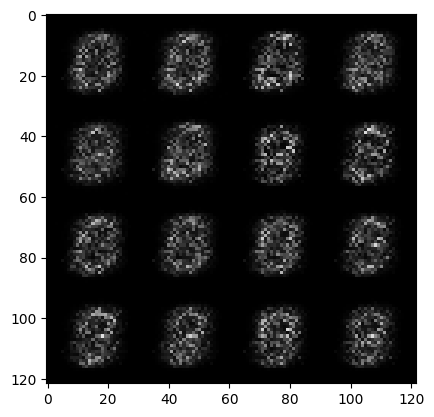

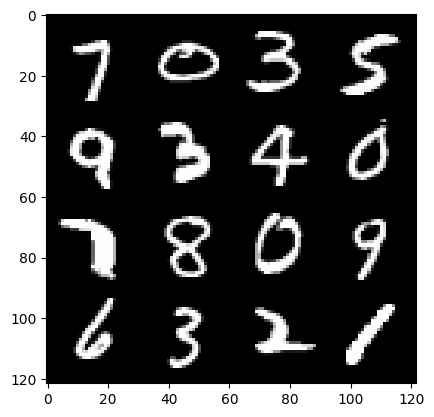

3: step 1800 / Gen loss: 3.2556604981422415 / disc_loss: 0.057096628298362075


  0%|          | 0/469 [00:00<?, ?it/s]

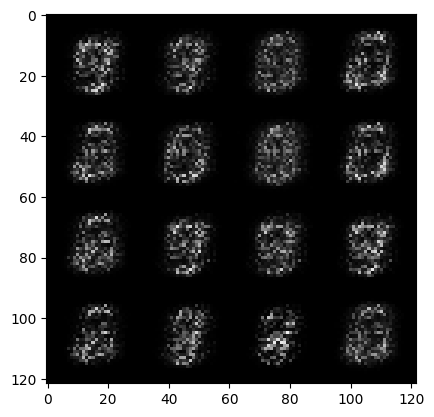

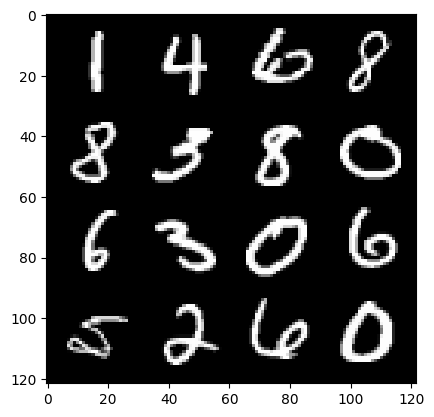

4: step 2100 / Gen loss: 3.4119039201736454 / disc_loss: 0.049039026511212204


  0%|          | 0/469 [00:00<?, ?it/s]

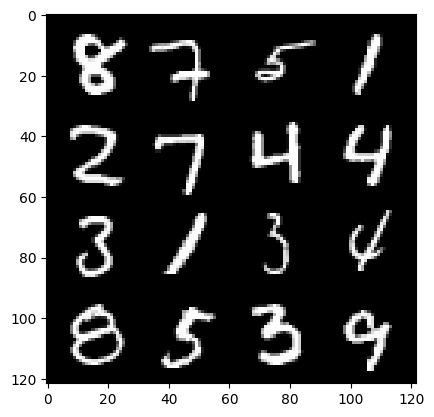

5: step 2400 / Gen loss: 3.8106185030937167 / disc_loss: 0.03707322465255856


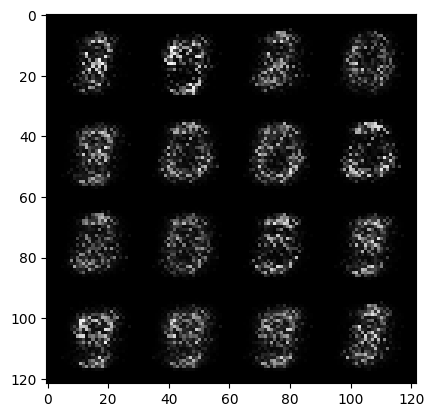

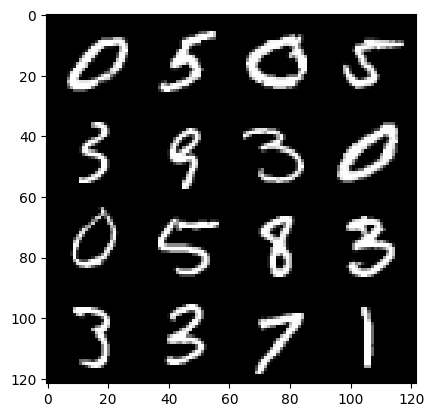

5: step 2700 / Gen loss: 4.256862256526947 / disc_loss: 0.03273552872861426


  0%|          | 0/469 [00:00<?, ?it/s]

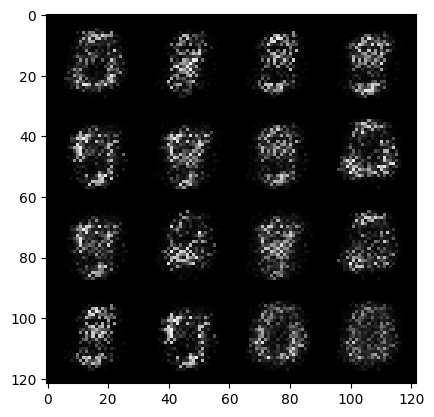

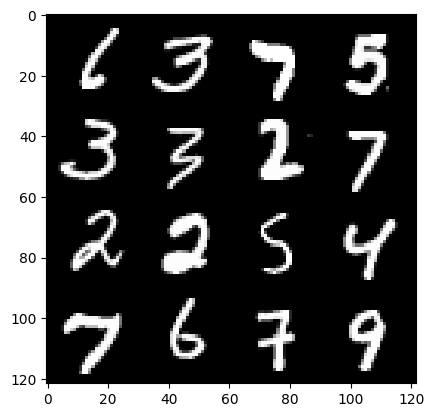

6: step 3000 / Gen loss: 4.659764575958252 / disc_loss: 0.02833248330590626


  0%|          | 0/469 [00:00<?, ?it/s]

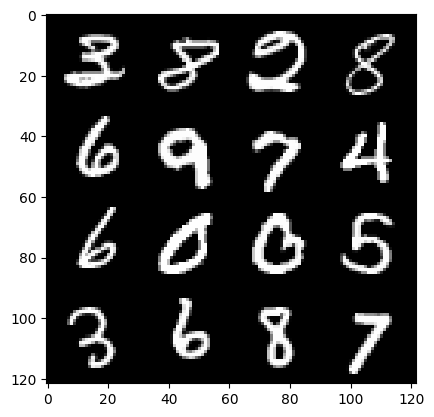

7: step 3300 / Gen loss: 5.021804986000061 / disc_loss: 0.024210512656718478


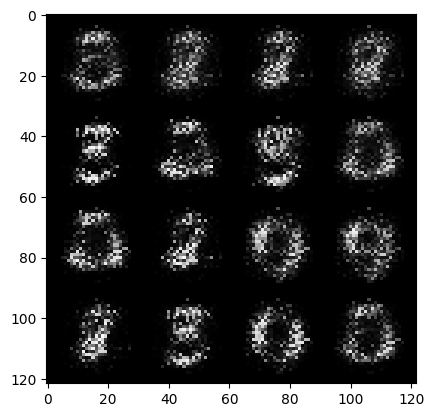

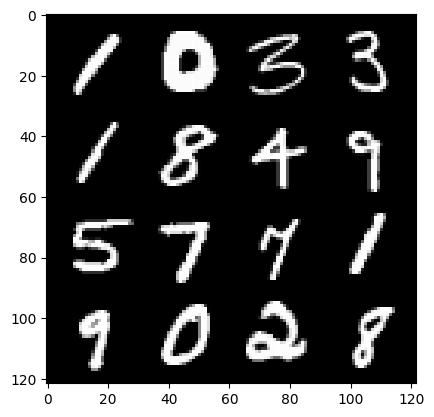

7: step 3600 / Gen loss: 4.978541269302368 / disc_loss: 0.02083777610523005


  0%|          | 0/469 [00:00<?, ?it/s]

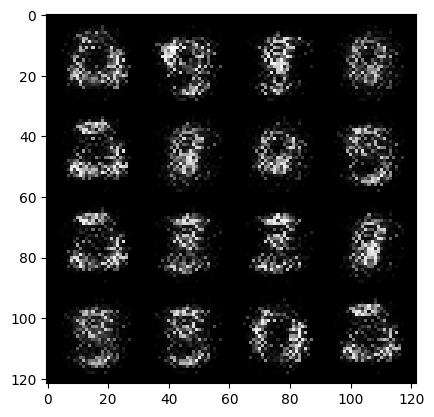

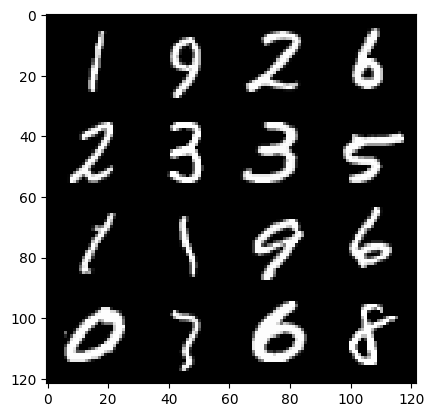

8: step 3900 / Gen loss: 5.238500521977744 / disc_loss: 0.01772992060830196


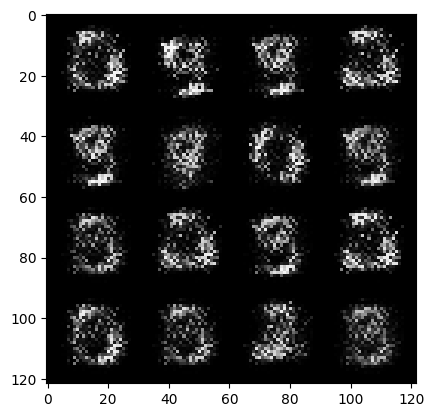

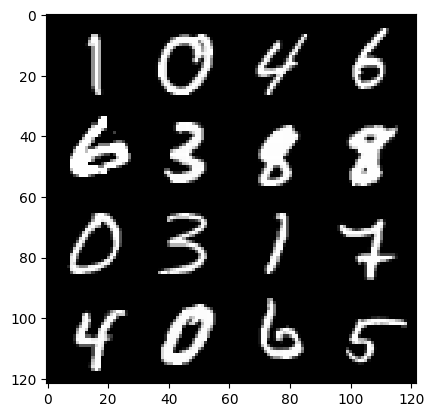

8: step 4200 / Gen loss: 5.942577234903974 / disc_loss: 0.016011259996642668


  0%|          | 0/469 [00:00<?, ?it/s]

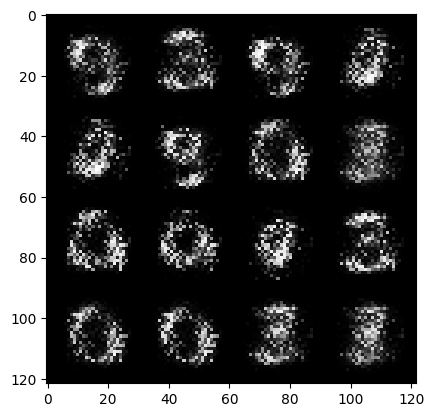

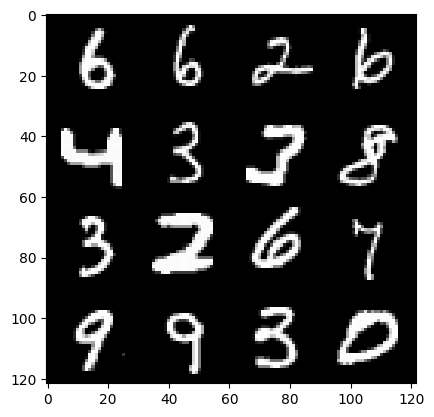

9: step 4500 / Gen loss: 6.049073247909547 / disc_loss: 0.012514958367682997


  0%|          | 0/469 [00:00<?, ?it/s]

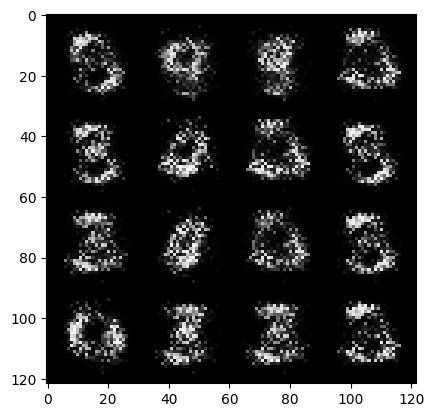

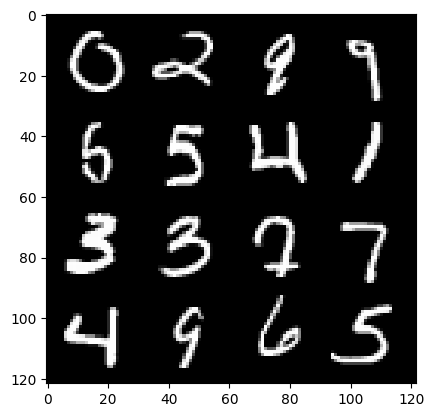

10: step 4800 / Gen loss: 6.0260360892613765 / disc_loss: 0.013893979879406597


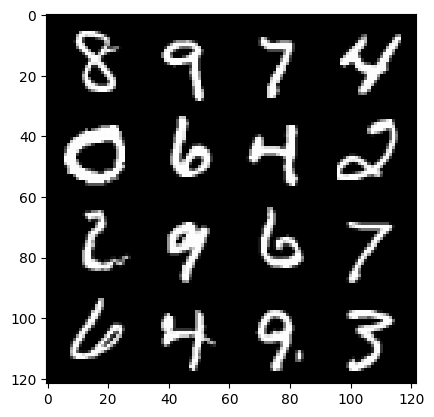

10: step 5100 / Gen loss: 5.957071839968361 / disc_loss: 0.013799590788160763


  0%|          | 0/469 [00:00<?, ?it/s]

11: step 5400 / Gen loss: 6.103992951711021 / disc_loss: 0.011872615349323795


  0%|          | 0/469 [00:00<?, ?it/s]

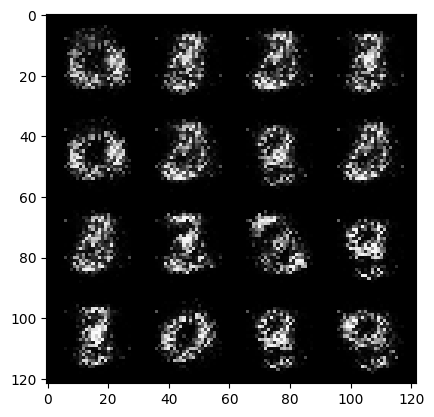

12: step 5700 / Gen loss: 6.297198847134909 / disc_loss: 0.011470922278240326


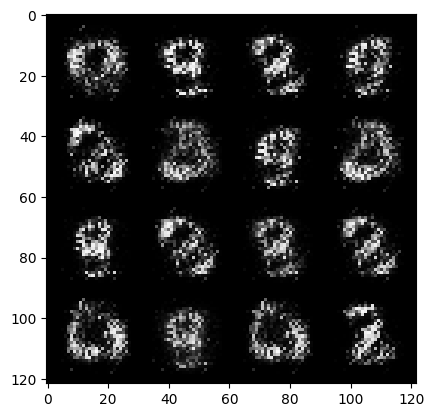

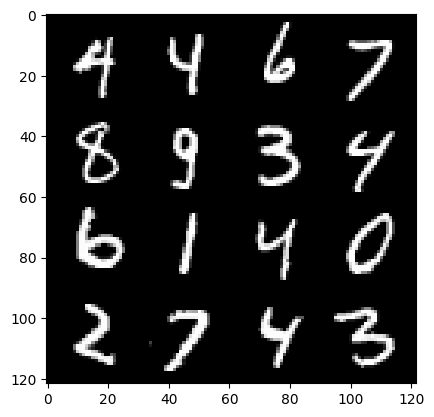

12: step 6000 / Gen loss: 6.6597253195444726 / disc_loss: 0.01047441444359719


  0%|          | 0/469 [00:00<?, ?it/s]

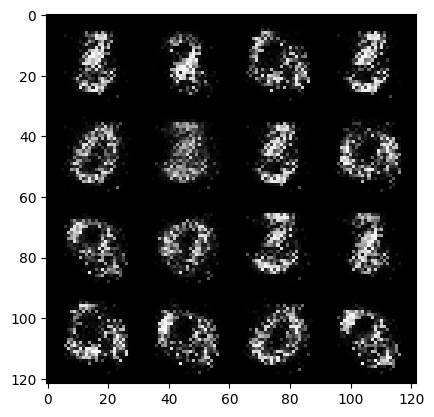

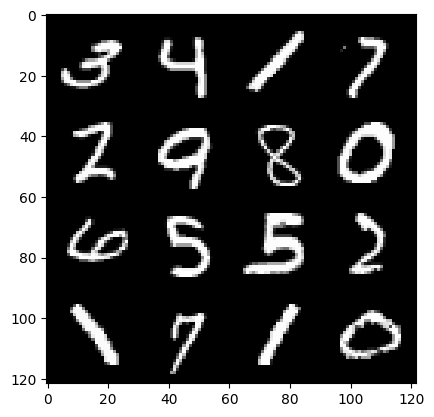

13: step 6300 / Gen loss: 6.300946140289309 / disc_loss: 0.01144405539807243


  0%|          | 0/469 [00:00<?, ?it/s]

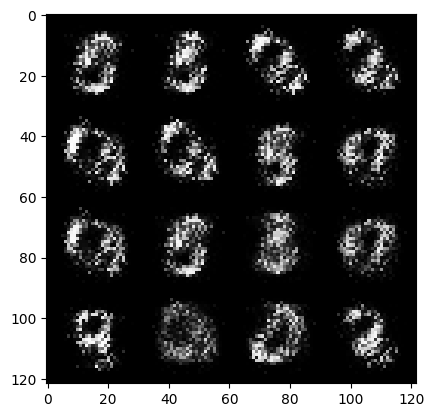

14: step 6600 / Gen loss: 6.570526630083719 / disc_loss: 0.011363498643040657


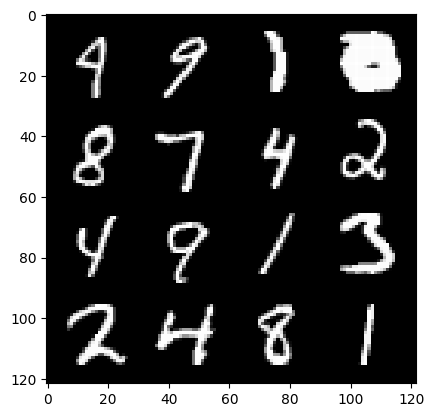

14: step 6900 / Gen loss: 6.67463546117147 / disc_loss: 0.013034350213129077


  0%|          | 0/469 [00:00<?, ?it/s]

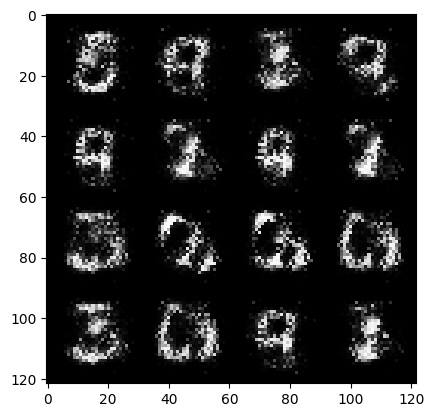

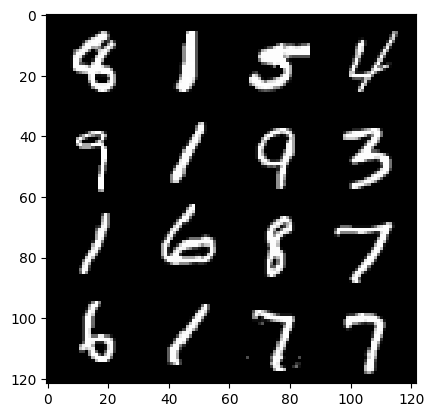

15: step 7200 / Gen loss: 6.330940076510108 / disc_loss: 0.014306036074024923


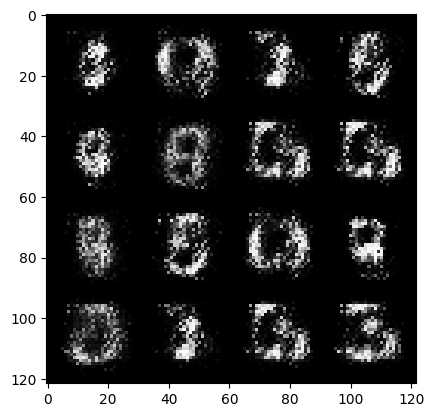

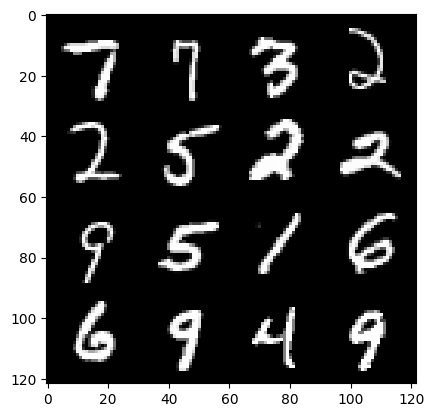

15: step 7500 / Gen loss: 6.662619056701661 / disc_loss: 0.012233372676031034


  0%|          | 0/469 [00:00<?, ?it/s]

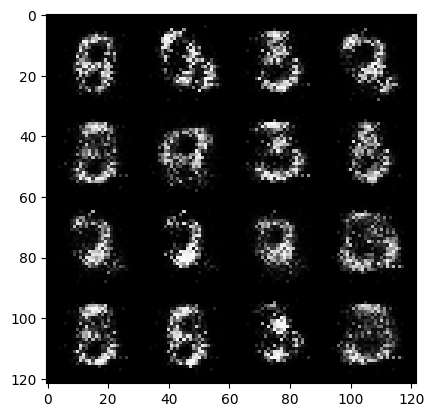

16: step 7800 / Gen loss: 6.668359100023907 / disc_loss: 0.012336333306351054


  0%|          | 0/469 [00:00<?, ?it/s]

17: step 8100 / Gen loss: 6.954218845367436 / disc_loss: 0.010154787071514881


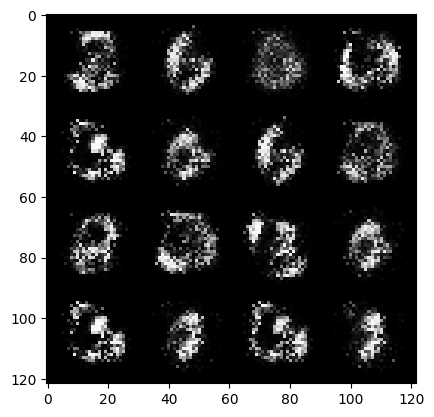

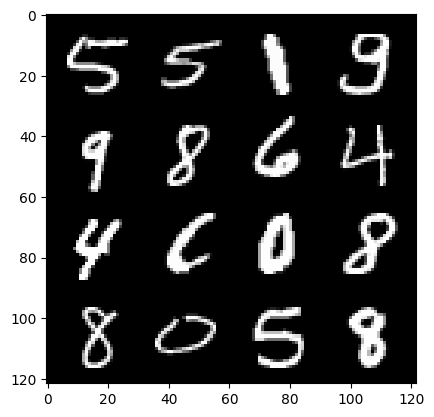

17: step 8400 / Gen loss: 6.74451484839122 / disc_loss: 0.012372381063954286


  0%|          | 0/469 [00:00<?, ?it/s]

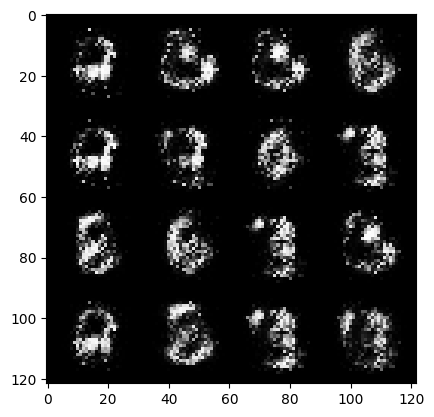

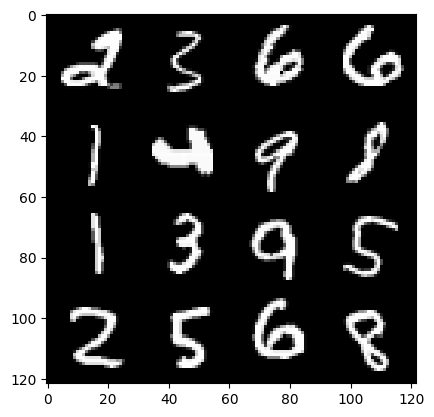

18: step 8700 / Gen loss: 7.11321518103282 / disc_loss: 0.01234938246042778


  0%|          | 0/469 [00:00<?, ?it/s]

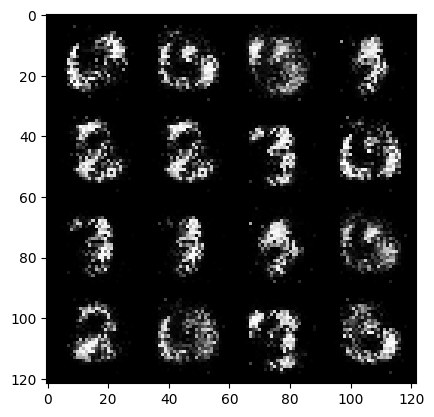

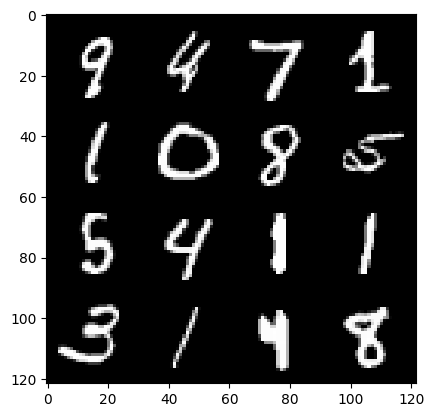

19: step 9000 / Gen loss: 7.104607718785601 / disc_loss: 0.011553105225320904


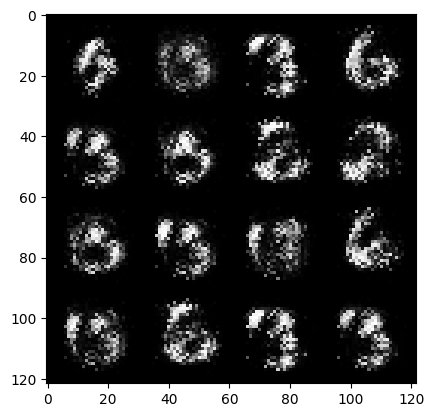

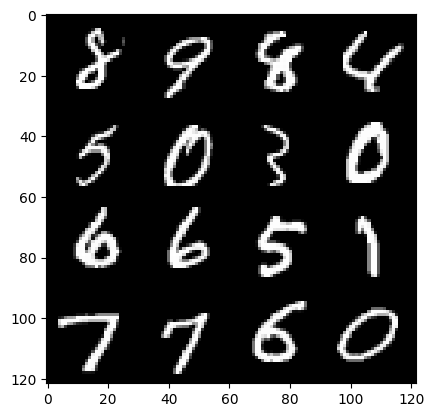

19: step 9300 / Gen loss: 6.756050788561508 / disc_loss: 0.010102838661211234


  0%|          | 0/469 [00:00<?, ?it/s]

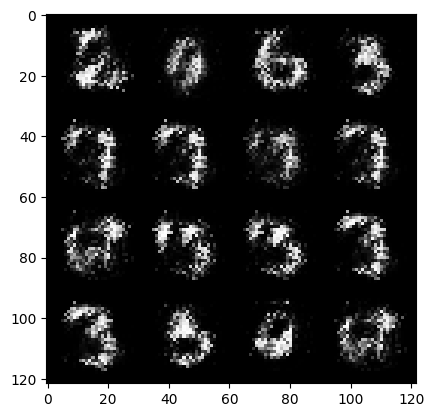

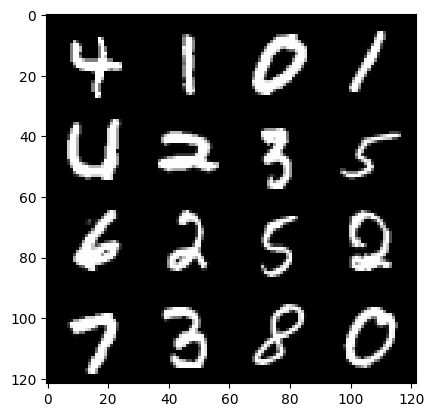

20: step 9600 / Gen loss: 6.560140360196435 / disc_loss: 0.012864441083123283


  0%|          | 0/469 [00:00<?, ?it/s]

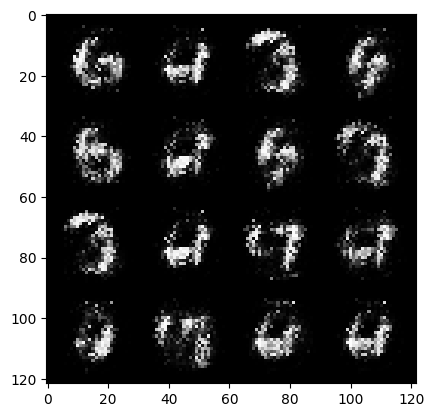

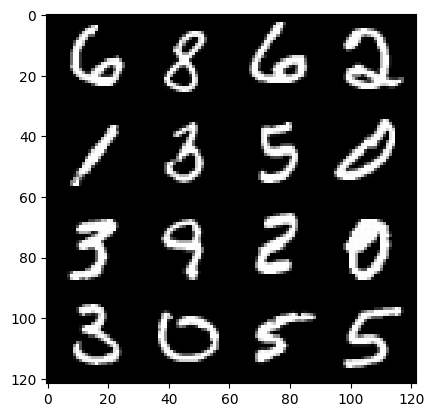

21: step 9900 / Gen loss: 6.2799898465474415 / disc_loss: 0.011912994260589276


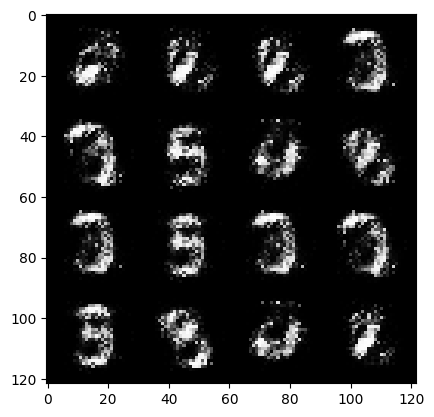

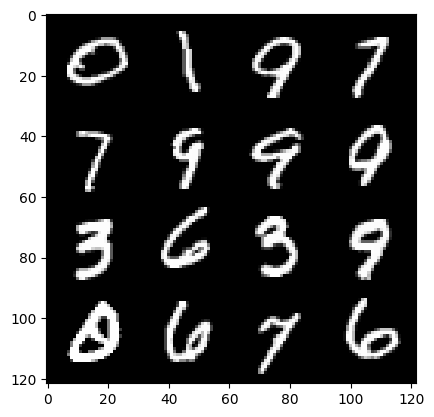

21: step 10200 / Gen loss: 6.506965352694189 / disc_loss: 0.01696959171754619


  0%|          | 0/469 [00:00<?, ?it/s]

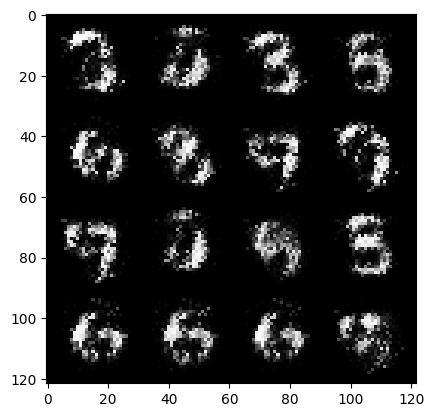

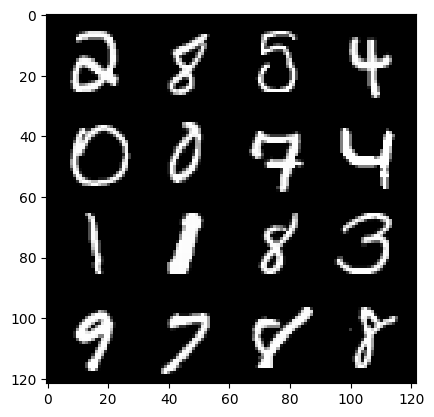

22: step 10500 / Gen loss: 6.097040902773537 / disc_loss: 0.021620862465351838


  0%|          | 0/469 [00:00<?, ?it/s]

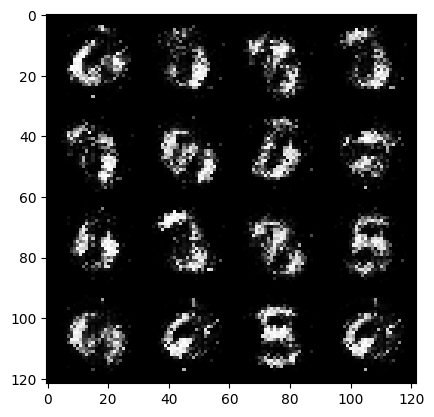

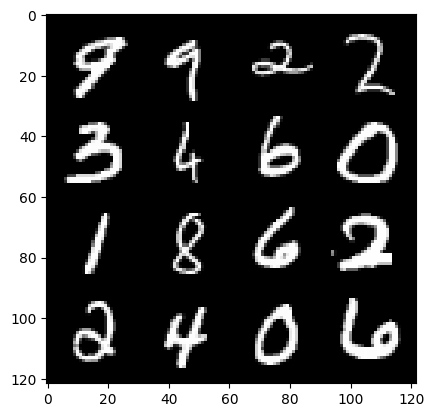

23: step 10800 / Gen loss: 6.634924613634745 / disc_loss: 0.014973069379727037


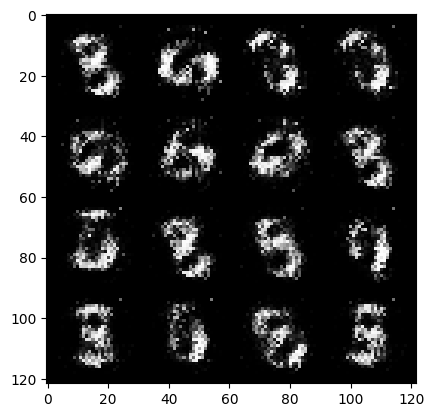

23: step 11100 / Gen loss: 6.908037444750468 / disc_loss: 0.011350959490519015


  0%|          | 0/469 [00:00<?, ?it/s]

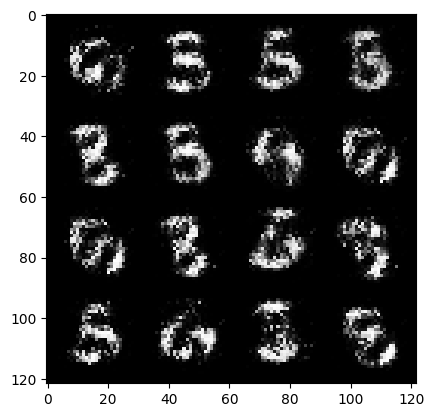

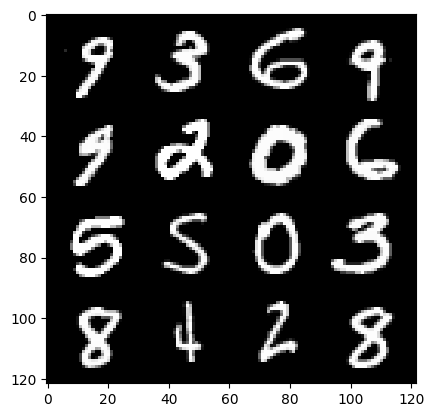

24: step 11400 / Gen loss: 6.978859017690025 / disc_loss: 0.013656514580361555


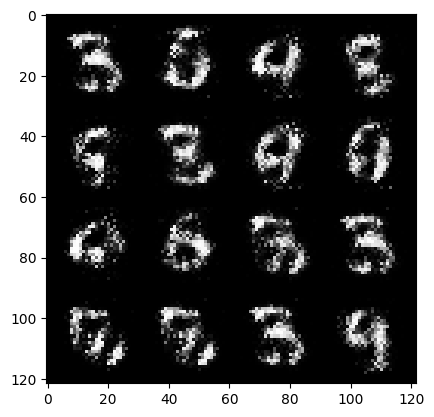

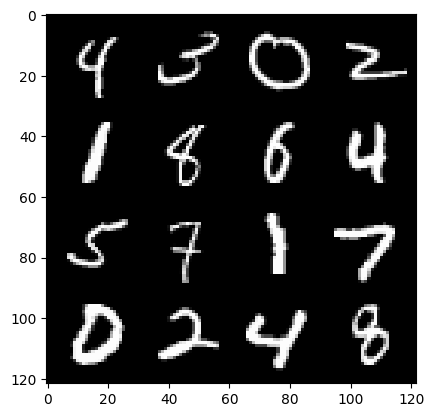

24: step 11700 / Gen loss: 6.479550407727562 / disc_loss: 0.015461984009792403


  0%|          | 0/469 [00:00<?, ?it/s]

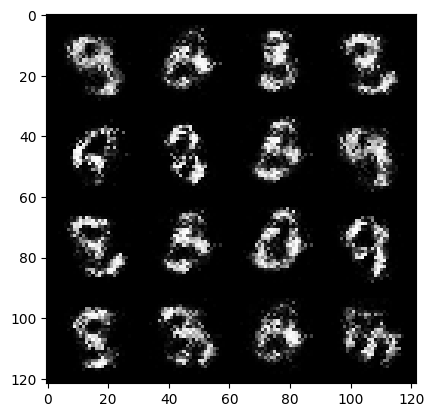

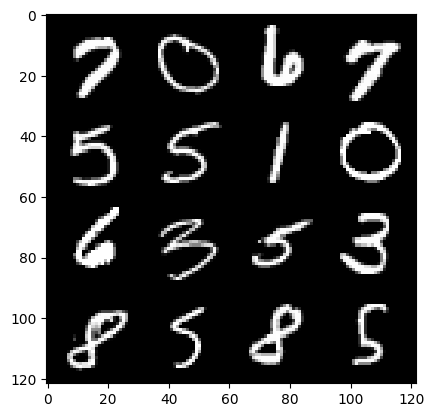

25: step 12000 / Gen loss: 6.2980433829625415 / disc_loss: 0.01790997475696108


  0%|          | 0/469 [00:00<?, ?it/s]

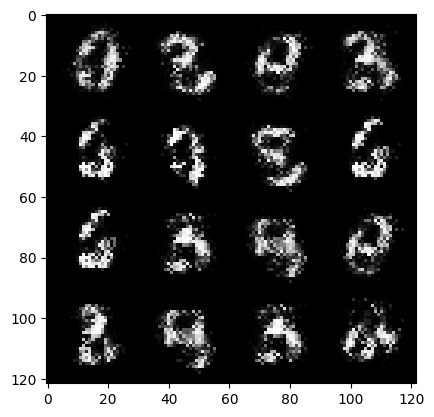

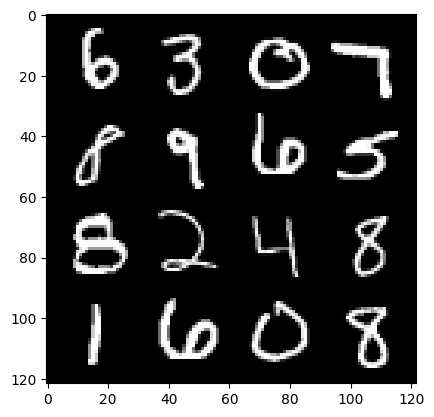

26: step 12300 / Gen loss: 6.201716057459513 / disc_loss: 0.017300366074778136


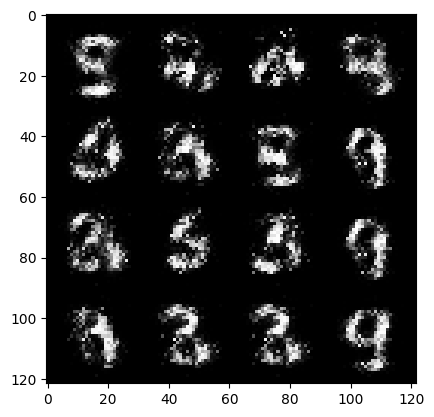

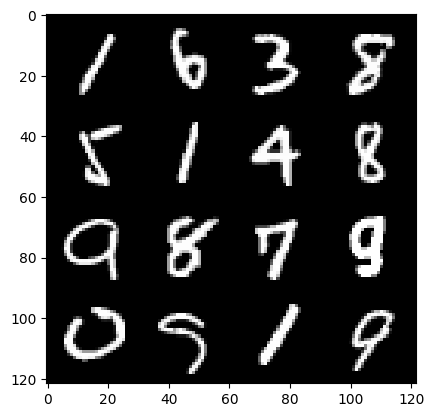

26: step 12600 / Gen loss: 6.336551842689513 / disc_loss: 0.020835272601495217


  0%|          | 0/469 [00:00<?, ?it/s]

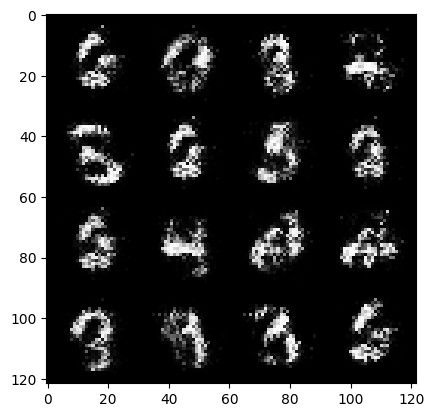

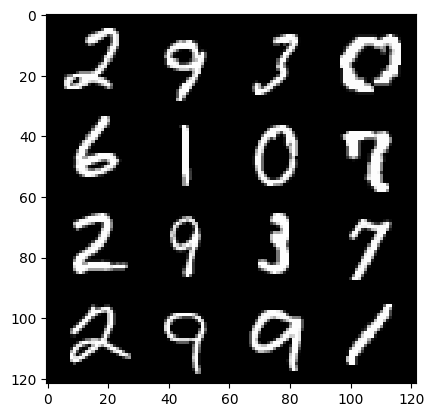

27: step 12900 / Gen loss: 5.9793567975362185 / disc_loss: 0.025293464572168904


  0%|          | 0/469 [00:00<?, ?it/s]

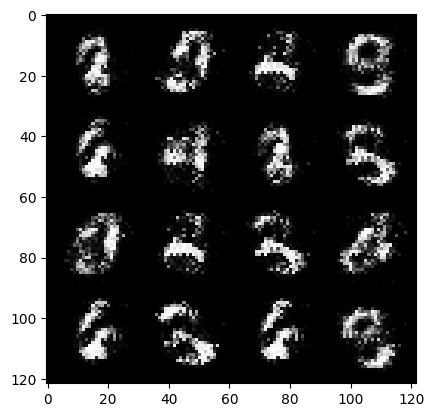

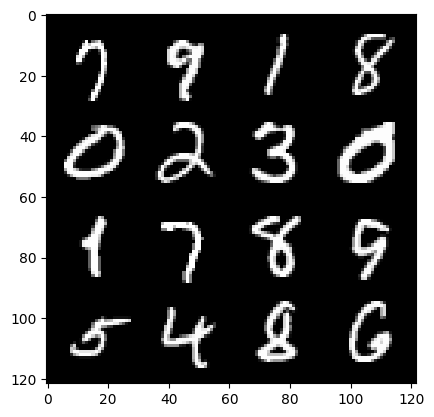

28: step 13200 / Gen loss: 6.0752555227279625 / disc_loss: 0.02330914096285899


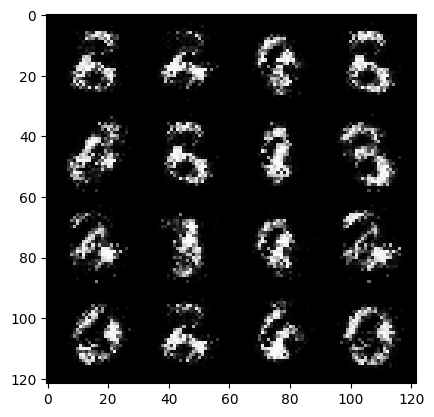

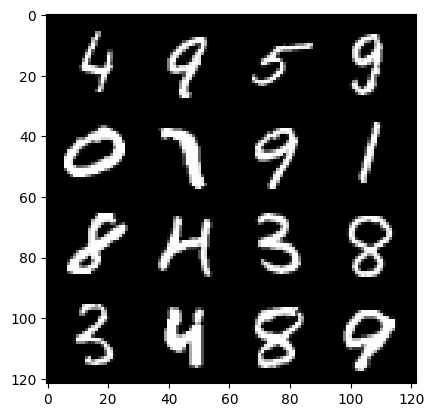

28: step 13500 / Gen loss: 6.321592820485431 / disc_loss: 0.01936906509256612


  0%|          | 0/469 [00:00<?, ?it/s]

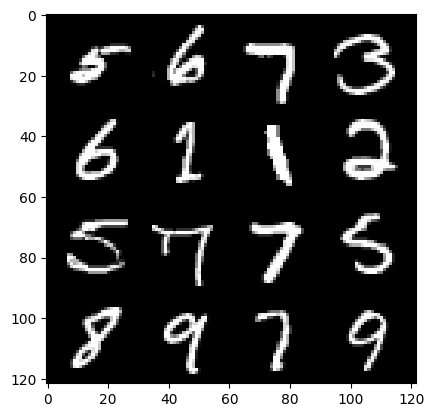

29: step 13800 / Gen loss: 6.311493231455489 / disc_loss: 0.01740288995361577


  0%|          | 0/469 [00:00<?, ?it/s]

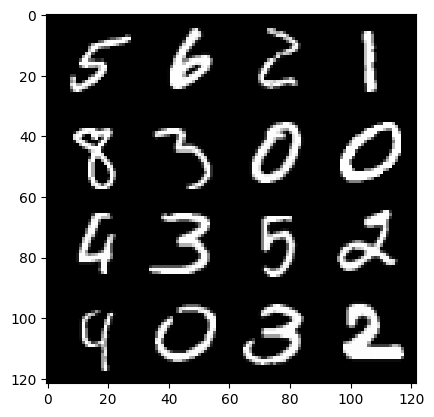

30: step 14100 / Gen loss: 6.368261113166809 / disc_loss: 0.01937628983675193


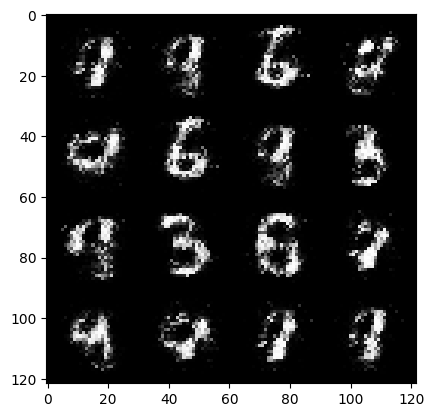

30: step 14400 / Gen loss: 6.1764085896809915 / disc_loss: 0.022224110721920935


  0%|          | 0/469 [00:00<?, ?it/s]

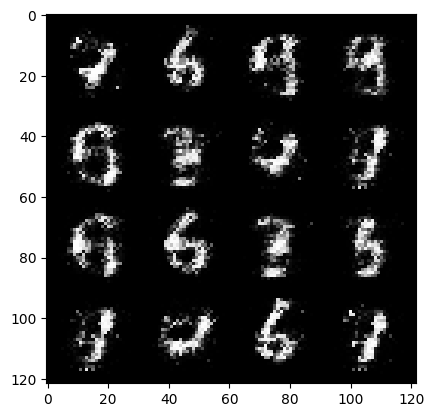

31: step 14700 / Gen loss: 6.129242494901026 / disc_loss: 0.024380702932054788


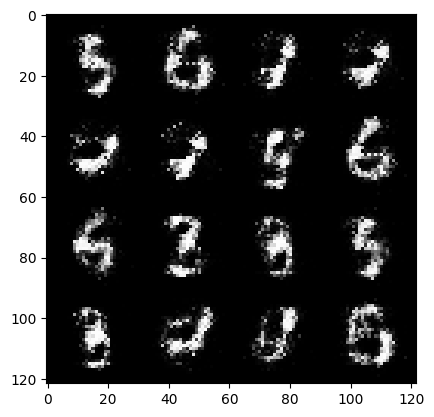

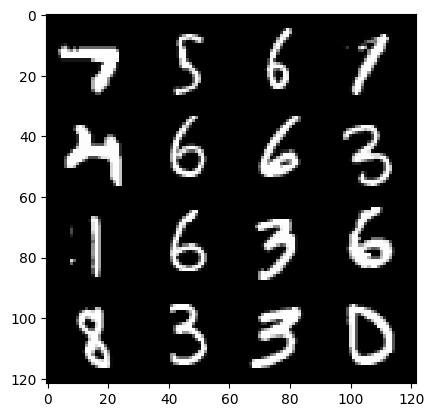

31: step 15000 / Gen loss: 6.157571659088135 / disc_loss: 0.022907913611270474


  0%|          | 0/469 [00:00<?, ?it/s]

32: step 15300 / Gen loss: 5.990394167900081 / disc_loss: 0.02488886817668875


  0%|          | 0/469 [00:00<?, ?it/s]

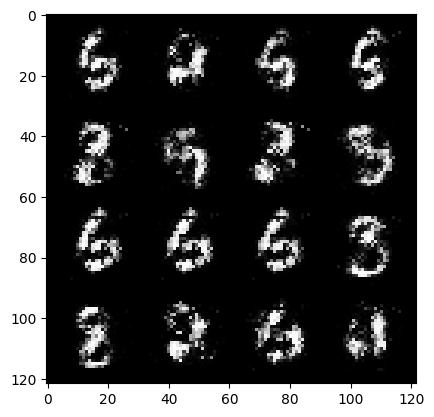

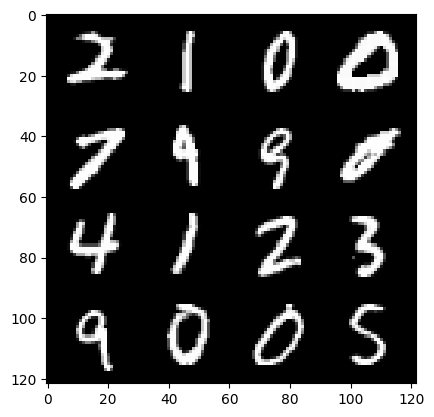

33: step 15600 / Gen loss: 5.76382565657298 / disc_loss: 0.02658423080885164


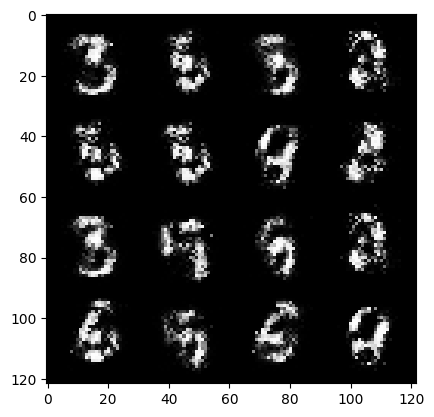

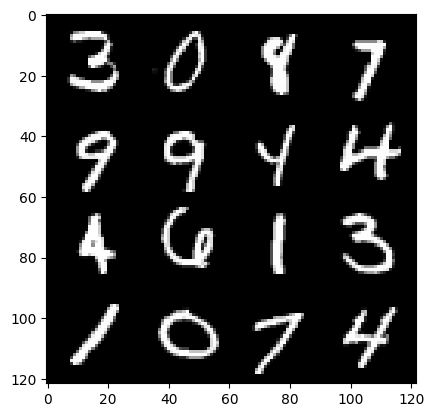

33: step 15900 / Gen loss: 5.887193843523659 / disc_loss: 0.02583659295303129


  0%|          | 0/469 [00:00<?, ?it/s]

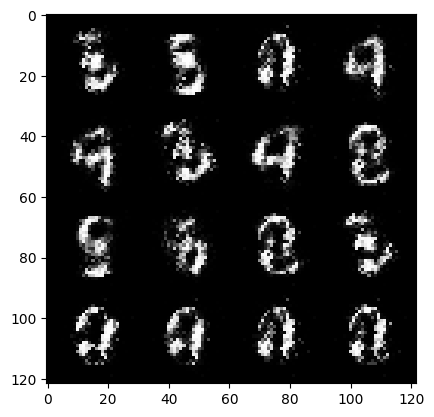

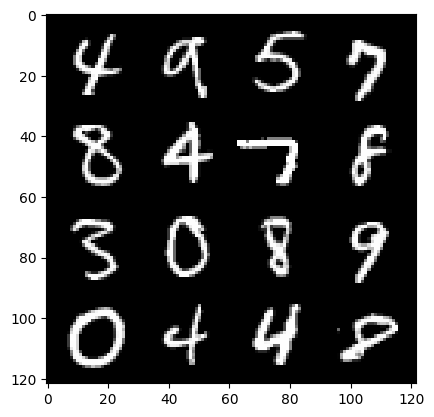

34: step 16200 / Gen loss: 5.8725068457921346 / disc_loss: 0.024495228747837244


  0%|          | 0/469 [00:00<?, ?it/s]

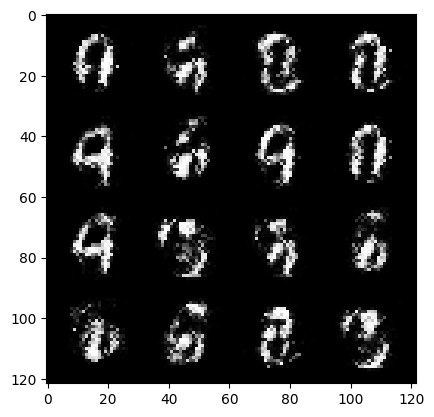

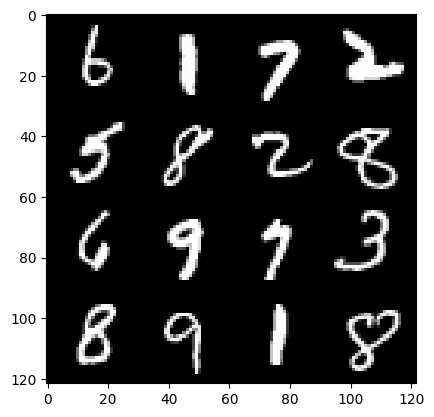

35: step 16500 / Gen loss: 5.811853739420568 / disc_loss: 0.029324698673250764


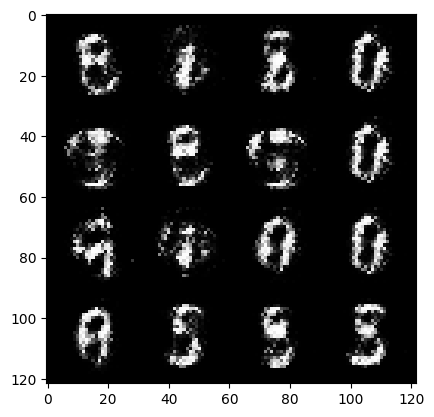

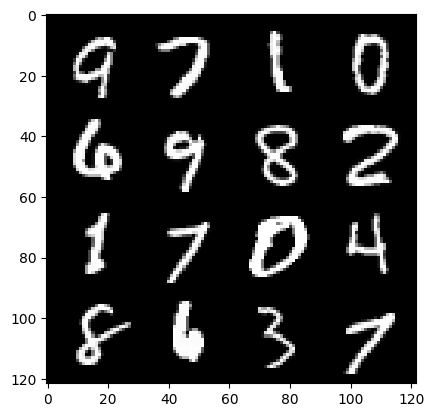

35: step 16800 / Gen loss: 5.802572476069135 / disc_loss: 0.03213361439605552


  0%|          | 0/469 [00:00<?, ?it/s]

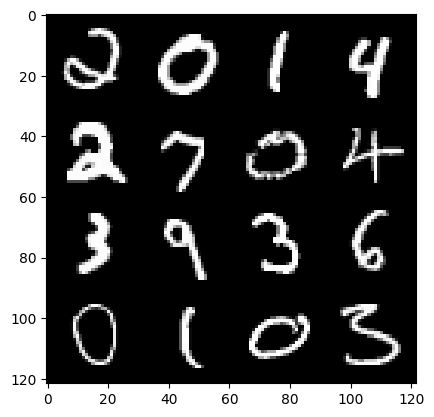

36: step 17100 / Gen loss: 5.843557214736938 / disc_loss: 0.036181525792926564


  0%|          | 0/469 [00:00<?, ?it/s]

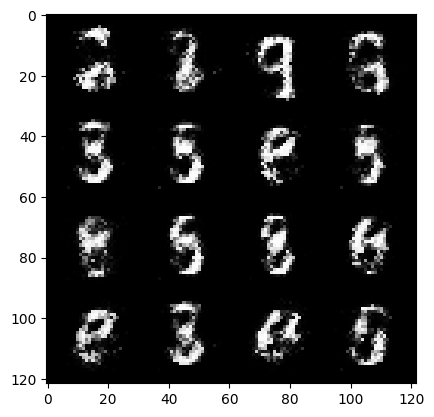

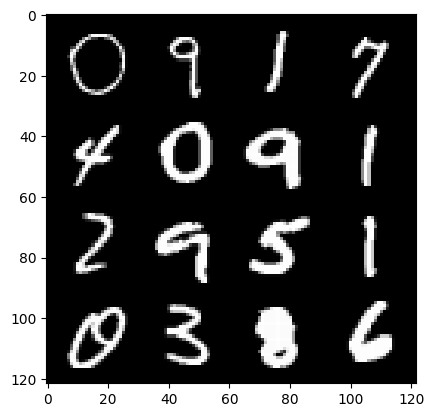

37: step 17400 / Gen loss: 5.873508024215699 / disc_loss: 0.035298841636007015


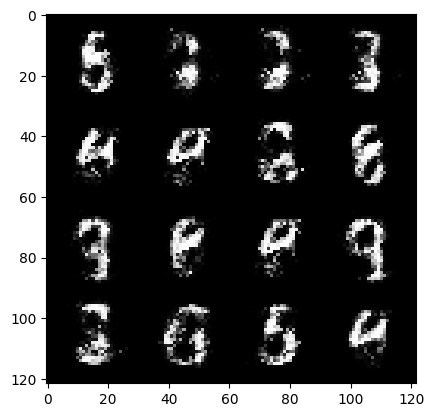

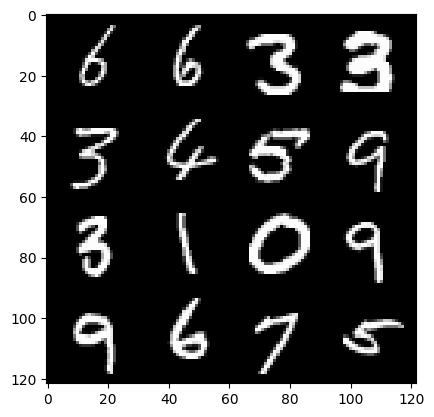

37: step 17700 / Gen loss: 5.831853791872665 / disc_loss: 0.029680755532657106


  0%|          | 0/469 [00:00<?, ?it/s]

38: step 18000 / Gen loss: 5.544790080388384 / disc_loss: 0.03590688096669814


  0%|          | 0/469 [00:00<?, ?it/s]

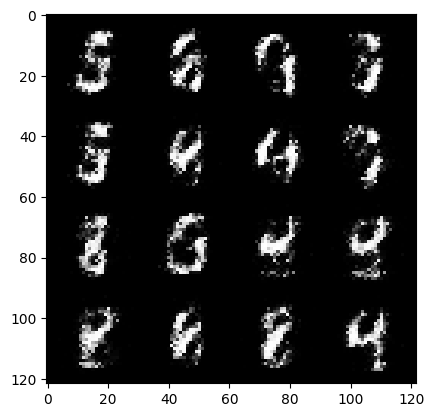

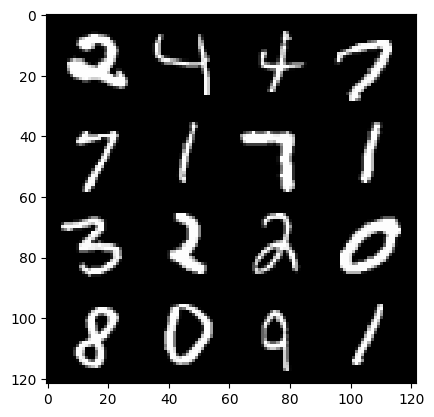

39: step 18300 / Gen loss: 5.890266070365906 / disc_loss: 0.03396866216324271


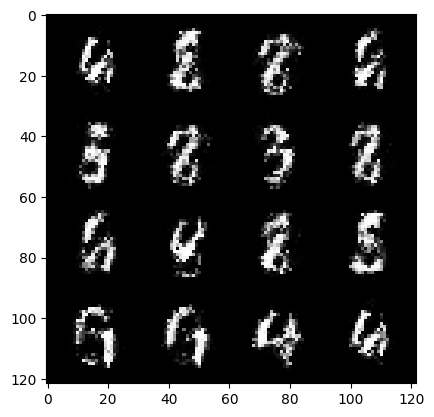

39: step 18600 / Gen loss: 6.043599543571471 / disc_loss: 0.030634002027412257


  0%|          | 0/469 [00:00<?, ?it/s]

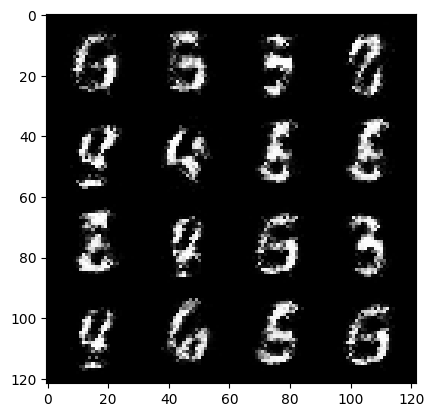

40: step 18900 / Gen loss: 5.733217873573309 / disc_loss: 0.036615297077223635


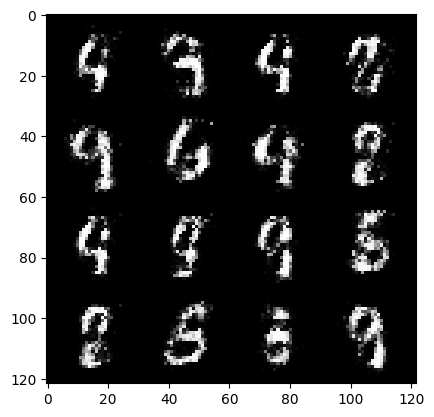

40: step 19200 / Gen loss: 5.721249232292174 / disc_loss: 0.03959487030127397


  0%|          | 0/469 [00:00<?, ?it/s]

41: step 19500 / Gen loss: 5.54593866348267 / disc_loss: 0.039294208502396934


  0%|          | 0/469 [00:00<?, ?it/s]

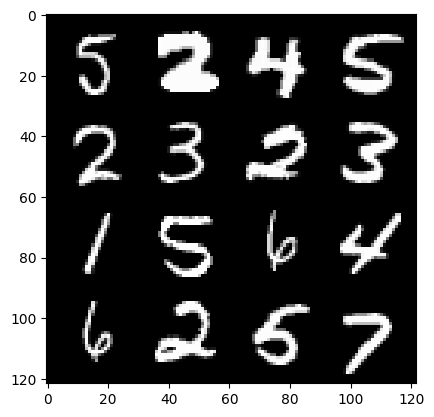

42: step 19800 / Gen loss: 5.640116791725159 / disc_loss: 0.04823496759558717


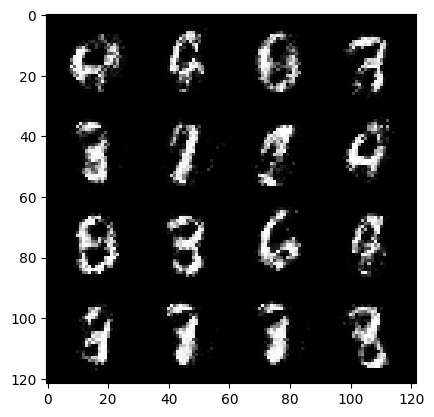

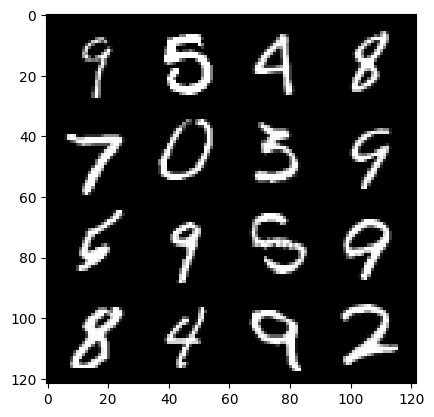

42: step 20100 / Gen loss: 5.239828534126281 / disc_loss: 0.04759036367759107


  0%|          | 0/469 [00:00<?, ?it/s]

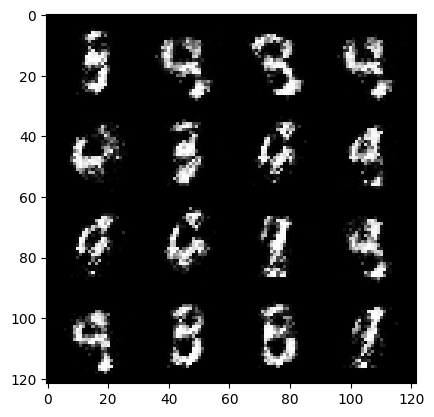

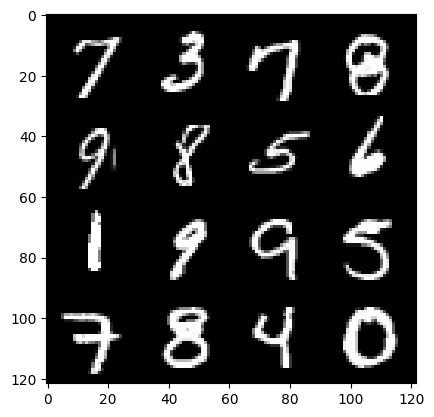

43: step 20400 / Gen loss: 5.163512123425804 / disc_loss: 0.05078550777398048


  0%|          | 0/469 [00:00<?, ?it/s]

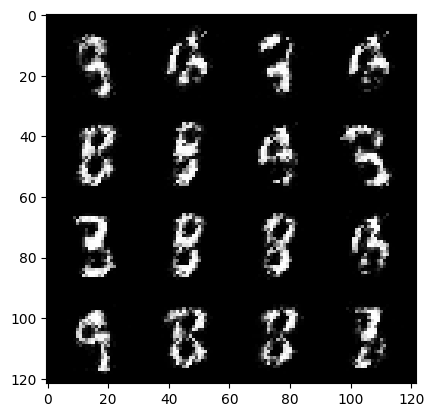

44: step 20700 / Gen loss: 5.405879135131831 / disc_loss: 0.0444381891501447


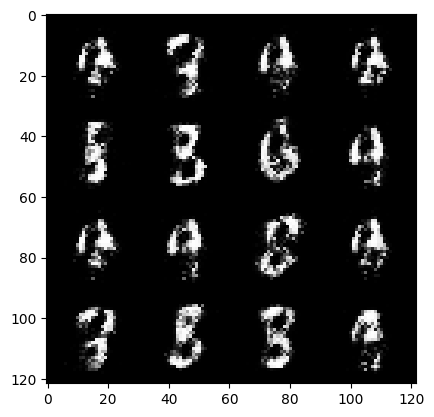

44: step 21000 / Gen loss: 5.26181912819545 / disc_loss: 0.047122303913347464


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1
